# Recovering Köppen Climate Groupings with Machine Learning
## An exploratory analysis by Danny Foster, 2022
### Link to the notebook file:  

I have been intrigued by weather and geography for as long as I can remember. It seems that there is no limit to the range of weather patterns seen around the world. According to scientists at the California Institute of Technology’s IPAC research center, the extremes of the global temperatures range from -126 °F in Antarctica up to 136 °F in the Libyan desert. This range exceeds the temperature difference between boiling water and a 0 °F winter cold snap! While the beaches of Hawaii enjoy year-round warmth, the volcanic peaks of a couple of islands regularly see snowfall - even during the summer!

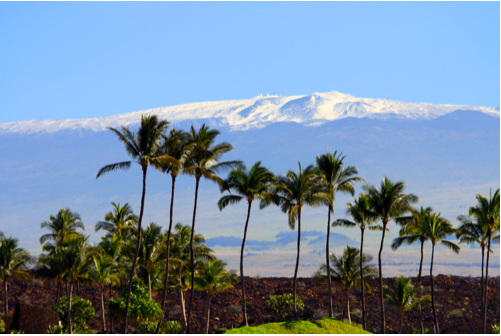

Mauna Kea in Hawaii, with snow. Photo courtesy of Big Island Visitors Bureau (BIVB) / <a href="https://kirkaederphoto.com/">Kirk Lee Aeder</a>

The influence that climate has on human activity is all but inescapable. Farmers around the world carefully time each stage of the growing process to optimize their yields. Aside from supporting life by providing food and raw materials, the US GCRP estimates that agriculture and related sectors accounted for $1.264 trillion in the US GDP in 2009.


Additionally, a location's climate can limit its access to transportation. The effect is much more noticeable for boats in cold climates. Many historians and geopolitical analysts suggest that much of Russia's foreign policy has been shaped by its reliance on cold-water ports which freeze during the harsh winters.

Because of the far-reaching impacts of climate (and the unique threats posed by changing climates), many scientists have worked to formalize a system to classify different climates based on their temperature and precipitation patterns. Modern climatologists use the term ‘climate’ to describe long-term patterns in atmospheric conditions. The Köppen climate classification system is the most widely-used technique to group locations based on their average monthly temperatures and precipitation. A map of the world by climate is shown below. 

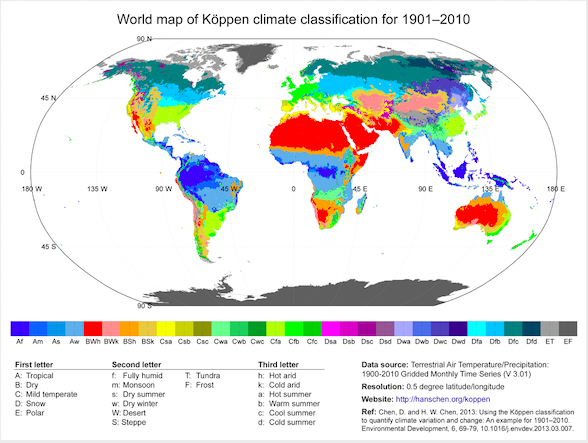


Map of the Köppen climates around the world. Map courtesy of <a href="http://hanschen.org/">Hans W. Chen</a>.


The way that a location is assigned to these groupings is based on a set of equations and inequalities against some reference values. For instance, the available climate assignments for a location may be narrowed down to five by considering the temperatures of the hottest and coldest months. The climate can be deduced after considering the amount of rain in the wettest and driest months. 


Some of the criticism for this model relates to the arbitrary decision for cutoffs between climate types. For example, for a climate to be tropical in this model, the coldest month must have a mean temperature above 22°C.

After hearing about this criticism, I wanted to see if I could use K-means clustering to group locations based on monthly temperature and precipitation data. In addition, I wanted to investigate the degree to which certain Köppen climates tended to co-occur in the resulting clusters. In doing so, I hope to learn more about the utility of K-means clustering in grouping climates and compare its utility to that of the Köppen model.

## Collecting a list of cities and their corresponding Wikipedia articles

To begin this project, I needed a reference containing the climate classification and monthly weather averages for a range of cities around the globe. After searching for some APIs, Python modules, or free websites to scrape, I realized that Wikipedia would be my best option. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import wikipedia
import requests

I searched for a list of global cities to reference and picked the most relevant article:

In [3]:
wikipedia.search('list of largest cities')

['List of largest cities',
 'List of United States cities by population',
 'List of largest cities by area',
 'List of largest cities throughout history',
 'List of largest cities in California by population',
 'List of cities in Brazil by population',
 'List of largest cities of Iraq',
 'List of cities in Australia by population',
 'List of largest cities of Iran',
 'List of European cities by population within city limits']

In [4]:
MyPage=wikipedia.WikipediaPage('List of largest cities').url
MyPage

'https://en.wikipedia.org/wiki/List_of_largest_cities'

Using the BeautifulSoup library, I can easily turn the article's main table into a pandas DataFrame. The structure of the code is fairly boilerplate; I just needed to open the page in a web browser and inspect the HTML source code to tell the library that I wanted to extract information tabular data by passing 'table.' I also passed 'wikitable', the HTML class containing the information I wanted.

In [5]:
page_response = requests.get(MyPage)
tables = BeautifulSoup(page_response.text, 'html.parser')
tab = tables.find('table', {'class' : 'wikitable'})
df = pd.read_html(str(tab))
df = pd.DataFrame(df[0])

Included in this table are the populations, areas, and population density statistics. These may come in handy for future projects.

In [7]:
tentative_cities = df['City[a]'].dropna().to_numpy().flatten()
tentative_cities

array(['Tokyo', 'Delhi', 'Shanghai', 'São Paulo', 'Mexico City', 'Cairo',
       'Mumbai', 'Beijing', 'Dhaka', 'Osaka', 'New York', 'Karachi',
       'Buenos Aires', 'Chongqing', 'Istanbul', 'Kolkata', 'Manila',
       'Lagos', 'Rio de Janeiro', 'Tianjin', 'Kinshasa', 'Guangzhou',
       'Los Angeles', 'Moscow', 'Shenzhen', 'Lahore', 'Bangalore',
       'Paris', 'Bogotá', 'Jakarta', 'Chennai', 'Lima', 'Bangkok',
       'Seoul', 'Nagoya', 'Hyderabad', 'London', 'Tehran', 'Chicago',
       'Chengdu', 'Nanjing', 'Wuhan', 'Ho Chi Minh City', 'Luanda',
       'Ahmedabad', 'Kuala Lumpur', "Xi'an", 'Hong Kong', 'Dongguan',
       'Hangzhou', 'Foshan', 'Shenyang', 'Riyadh', 'Baghdad', 'Santiago',
       'Surat', 'Madrid', 'Suzhou', 'Pune', 'Harbin', 'Houston', 'Dallas',
       'Toronto', 'Dar es Salaam', 'Miami', 'Belo Horizonte', 'Singapore',
       'Philadelphia', 'Atlanta', 'Fukuoka', 'Khartoum', 'Barcelona',
       'Johannesburg', 'Saint Petersburg', 'Qingdao', 'Dalian',
       'Washington

Next, I use the Wikipedia Python library to find the articles corresponding to the cities in my 'tentative_cities' list. Each article is stored to the corresponding city name in a dictionary:

In [8]:
wikipedia_pages = {}
for k in tentative_cities:
    try:
        a = wikipedia.WikipediaPage(k).url
        wikipedia_pages.update({k : a})
    except:
        print(f'Error finding article for {k}')

/opt/anaconda3/lib/python3.9/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/anaconda3/lib/python3.9/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Error finding article for New York
Error finding article for Washington


Only 2 articles were not found. I think this is because "New York" and "Washington" both refer to US states as well as cities, so the user must specify "New York City" or "Washington, D.C."

## Collecting the Köppen classifications for each city

In order to simplify the analysis, I chose to group related climates together. The names of the climate types as they would appear in a Wikipedia article (either in an abbreviated format like 'Dfa' or in a long format like 'humid continental climate') are stored in a dictionary to link them to the corresponding climate group.

In [39]:
af_names = ['Af', 'tropical rainforest climate']
am_names = ['Am', 'tropical monsoon climate']
tropical_savanna_names = ['Aw', 'tropical wet and dry climate', 'tropical savanna climate']
bwh_names = ['BWh', 'hot desert climate']
bwk_names = ['BWk', 'cold desert climate']
bsh_names = ['BSh', 'hot semi-arid climate']
bsk_names = ['BSk', 'cold semi-arid climate']
cfa_names = ['Cfa', 'Cwa', 'humid subtropical climate']
cfb_names = ['Cfb', 'Cwb', 'Cwc','oceanic climate', 'subtropical highland climate', 'marine west coast climate', 'marine climate']
cfc_names = ['Cfc', 'subpolar oceanic climate']
mediterranean_names = ['Csa', 'Csb', 'Csc', 'Mediterranean  climate']
continental_names = ['continental climate', 'Dfa', 'Dfb', 'Dsa', 'Dsb', 'Dwa', 'Dwb']
sub_arctic_names = ['Dfc', 'Dfd', 'Dwc', 'Dwd', 'Dsc', 'Dsd', 'subarctic climate']
polar_names = ['ET', 'EF', 'polar', 'alpine climate', 'ice cap']

my_names = [af_names, am_names, tropical_savanna_names, bwh_names, bwk_names, bsh_names, bsk_names,
           cfa_names, cfb_names, cfc_names, mediterranean_names, sub_arctic_names, polar_names]


key_names = {'Af' : af_names, 'Am' : am_names, 'trop_sav' : tropical_savanna_names,
            'BWh' : bwh_names, 'BWk' : bwk_names, 'BSh' : bsh_names, 'BSk' : bsk_names,
             'Cfa' : cfa_names, 'Cfb' : cfb_names, 'Cfc' : cfc_names, 'med' : mediterranean_names,
             'cont' : continental_names, 'subarctic' : sub_arctic_names, 'polar' : polar_names
            }
climate_categories = {}

for i in key_names:
    for j in key_names[i]:
        climate_categories.update({j : i})

Collecting the Köppen classifications for each of the cities took more effort than extracting the monthly averages because it is contained in human language. This information is found under a 'Climate' subcategory of the Wikipedia articles. 

My first approach was to find sentences that mention certain climate types such as "Dfa", "tropical monsoon climate", etc. However, this produced some inaccurate results such as assigning a tropical climate to Tokyo. After inspecting this article, I realized that it included additional information about the climate of island territories included in the Tokyo Prefecture. 

To get cleaner data, I chose to favor sentences that included the city name, occurred towards the beginning of the section, and included one of the following 'identifier_words':

In [10]:
identifier_words = ["features", "majority", "displays", "lies", "lie", "experiences", "Koeppen", "Köppen", "Koppen"]

The following function will return the climate type of a city given its name. If no sentences contain any of the identifier words, the selection criteria are not met and no data is collected. This is to ensure that accurate data is being collected. The cities which return a climate type are my "finalist_cities."

In [40]:
def get_climate_sentence(city_name):
    try:
        string = wikipedia.WikipediaPage(city_name).section('Climate')
        sentences = string.split('.')
        for sentence in sentences:
            climate_references = {}
            for word in identifier_words:
                if (word in sentence):
                    for word in climate_categories:
                        if word in sentence:
                            index = sentence.index(word)
                            climate_references.update({index : climate_categories[word]})
            return climate_references[min(climate_references)]
    except:
        return False

In [41]:
finalist_cities = {}

for city in wikipedia_pages:
    result = get_climate_sentence(city)
    if result:
        finalist_cities.update({city:result})

finalist_cities
finalist_city_pages = {city:wikipedia_pages[city] for city in finalist_cities}

## Collecting Monthly Temperature and Precipitation Averages

In this section, I scrape the wikipedia articles for the monthly averages. Fortunately the structure of the web pages is fairly regular:
<br><br>
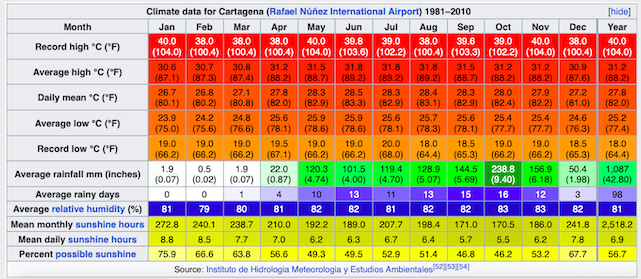

The first thing to notice is that the information I want is contained in the rows 'Daily mean' and 'Average rainfall'. Also, note that the units used are written immediately to the right of the row name: 'Average rainfall mm (inches)'. This allows me to determine what units are being used and how to convert them to a consistent set of units: cm for precipitation and °C for temperature. This is implemented below:

In [42]:
def city_to_averages(city_name):
    try:
        climate_table_class = 'wikitable mw-collapsible mw-made-collapsible'
        page_response = requests.get(wikipedia_pages[city_name])
        table = BeautifulSoup(page_response.text, 'html.parser')
        tab = table.find('table', {'class' : 'wikitable'})
        df = pd.DataFrame(pd.read_html(str(tab))[0])
        my_arr = df.to_numpy()
        tentative_dict = {}
        for row in my_arr:
            if 'Daily mean' in row[0]:
                if '(°F)' in row[0]:
                    offset = 0
                    multiplier = 1
                elif '(°C)' in row[0]:
                    offset = -32 * 5 / 9
                    multiplier = 5 / 9
                mean_temp = multiplier * np.array([float(x[0:x.index('(')].replace(',', ''))\
                                                   for x in row[1::]]) + offset
                tentative_dict.update({'Mean Temp' : mean_temp})
            if (('Average rainfall' in row[0]) or ('Average precipitation' in row[0])\
                and ('Average precipitation days' not in row[0])):
                if ' mm ' in row[0]:
                    unit = 'mm'
                    multiplier = 1/10
                elif ' cm ' in row[0]:
                    unit = 'cm'
                    multiplier = 1
                elif ' inches ' in row[0]:
                    unit = 'in'
                    multiplier = 2.54
                mean_rain = np.array([float(x[0:x.index('(')].replace(',', '')) for x in row[1::]])
                tentative_dict.update({'Mean Rain' : multiplier * mean_rain})
            if 'Average snowfall' in row[0]:
                if ' mm ' in row:
                    multiplier = 1/10
                elif ' cm ' in row[0]:
                    multiplier = 1
                elif ' inches ' in row[0]:
                    multiplier = 2.54
                my_snow = multiplier * np.array([x[0:x.index('(')].replace(',', '') for x in row[1::]])
                mean_prec = mean_rain + my_snow
                tentative_dict.update({'Mean Rain' : mean_prec})
            if (len(tentative_dict) == 2):
                return tentative_dict
    except:
        return False

Now I can organize the data into a dictionary with the following structure:

{'CityName' : {'Köppen': 'climate type', 'Mean Temp': array of mean temperatures, 'Mean Rain': array of mean precipitation}}

In [43]:
climate_data_table = {}
for i in finalist_city_pages:
    clim_dat = city_to_averages(i)
    if clim_dat:
        clim_dat.update({'Köppen': finalist_cities[i]})
        climate_data_table.update({i:clim_dat})

This dictionary can easily be turned into a pandas DataFrame:

In [44]:
climates = []
temps = []
rains = []

for val in list(climate_data_table.values()):
    climates.append(val["Köppen"])
    temps.append(val['Mean Temp'])
    rains.append(val['Mean Rain'])

df = pd.DataFrame({"Name": list(climate_data_table.keys()), "Climate" : climates, 
                   'Jan Temp' : np.array(temps)[:,0], 'Feb Temp' : np.array(temps)[:,1],
                   'Mar Temp': np.array(temps)[:,2], 'Apr Temp': np.array(temps)[:,3], 
                   'May Temp': np.array(temps)[:,4], 'Jun Temp': np.array(temps)[:,5], 
                   'Jul Temp': np.array(temps)[:,6], 'Aug Temp': np.array(temps)[:,7], 
                   'Sep Temp': np.array(temps)[:,8], 'Oct Temp': np.array(temps)[:,9], 
                   'Nov Temp': np.array(temps)[:,10], 'Dec Temp': np.array(temps)[:,11],  
                   'Mean Temp': np.array(temps)[:,12], 'Jan Prec' : np.array(rains)[:,0], 
                   'Feb Prec' : np.array(rains)[:,1], 'Mar Prec' : np.array(rains)[:,2], 
                   'Apr Prec' : np.array(rains)[:,3], 'May Prec' : np.array(rains)[:,4], 
                   'Jun Prec' : np.array(rains)[:,5], 'Jul Prec' : np.array(rains)[:,6], 
                   'Aug Prec' : np.array(rains)[:,7], 'Sep Prec' : np.array(rains)[:,8], 
                   'Oct Prec' : np.array(rains)[:,9], 'Nov Prec' : np.array(rains)[:,10], 
                   'Dec Prec' : np.array(rains)[:,11], 'Tot Prec' : np.array(rains)[:,12] })

## Clustering the Climate Data

To begin clustering the data, I need to separate and normalize the numeric data. I simply normalized each column with 0 being the minimum of the column and 1 being the maximum of the column. I then added the names and climates.

In [76]:
numeric_df = df.loc[: , "Jan Temp":"Tot Prec"]
normed_df = (numeric_df - numeric_df.min())/(numeric_df.max()-numeric_df.min())
normed_df = normed_df.join(df['Name'])
normed_df = normed_df.join(df['Climate'])

In [47]:
df["Climate"].nunique()

9

With 9 unique climate groups, we will try to use 9 clusters for the model.

In [57]:
from sklearn.cluster import KMeans


# Create a KMeans model:
kmeans = KMeans(n_clusters=9)

numeric_columns = ['Jan Temp', 'Feb Temp', 'Mar Temp', 'Apr Temp', 'May Temp', 'Jun Temp',
       'Jul Temp', 'Aug Temp', 'Sep Temp', 'Oct Temp', 'Nov Temp', 'Dec Temp',
       'Mean Temp', 'Jan Prec', 'Feb Prec', 'Mar Prec', 'Apr Prec', 'May Prec',
       'Jun Prec', 'Jul Prec', 'Aug Prec', 'Sep Prec', 'Oct Prec', 'Nov Prec',
       'Dec Prec', 'Tot Prec']

kmeans.fit(normed_df[numeric_columns])

KMeans(n_clusters=9)

We can fit the data into clusters using our model:

In [58]:
normed_df["cluster"] = kmeans.predict(normed_df[numeric_columns])
df["Cluster"] = normed_df["cluster"]

In [59]:
df_clusters=df.groupby(["Cluster"])

Now, we can see what the temperature plots for a sample cluster looks like:

<Figure size 240x240 with 0 Axes>

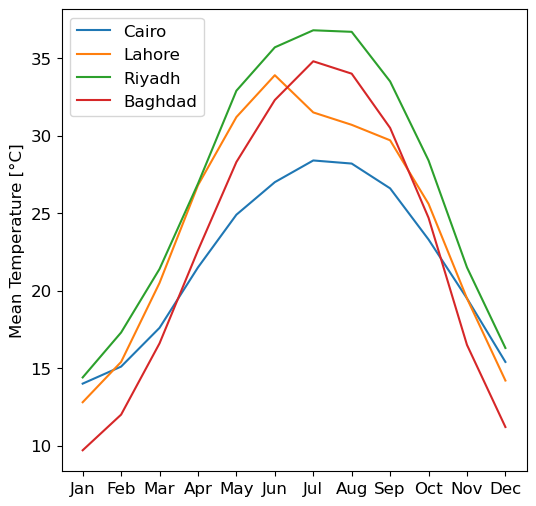

In [74]:
plt.figure(figsize=(3, 3), dpi=80)
plt.rcParams['figure.figsize'] = [6, 6]
df_clusters.get_group(2).loc[:,"Jan Temp":"Dec Temp"].T.plot()
plt.ylabel("Mean Temperature [°C]")
plt.xticks(np.arange(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(df_clusters.get_group(2)["Name"])

Let's see what each of the clusters look like for temperature:

In [ ]:
fig, axs  = plt.subplots(3, 3)
fig.suptitle('Monthly Temperature Variation by Cluster', fontsize = 42)
plt.figure(figsize=(20, 20), dpi=80)
plt.rcParams['figure.figsize'] = [30, 30]
plt.rcParams.update({'font.size': 12})

for i in range(9):
    x = i % 3
    y = (i - x) // 3
    df_clusters.get_group(i).loc[:,"Jan Temp":"Dec Temp"].T.plot(ax=axs[y, x])
    axs[y, x].legend(df_clusters.get_group(i)["Name"], fontsize=15)
    axs[y, x].set_ylim(-10, 40)
    axs[y, x].set_xticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr",
              "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize = 20,rotation=45)
    axs[y, x].set_ylabel("Monthly Mean Temp [°C]", fontsize=15)
    axs[y, x].set_title(f'Cluster: {i}', fontsize=22)

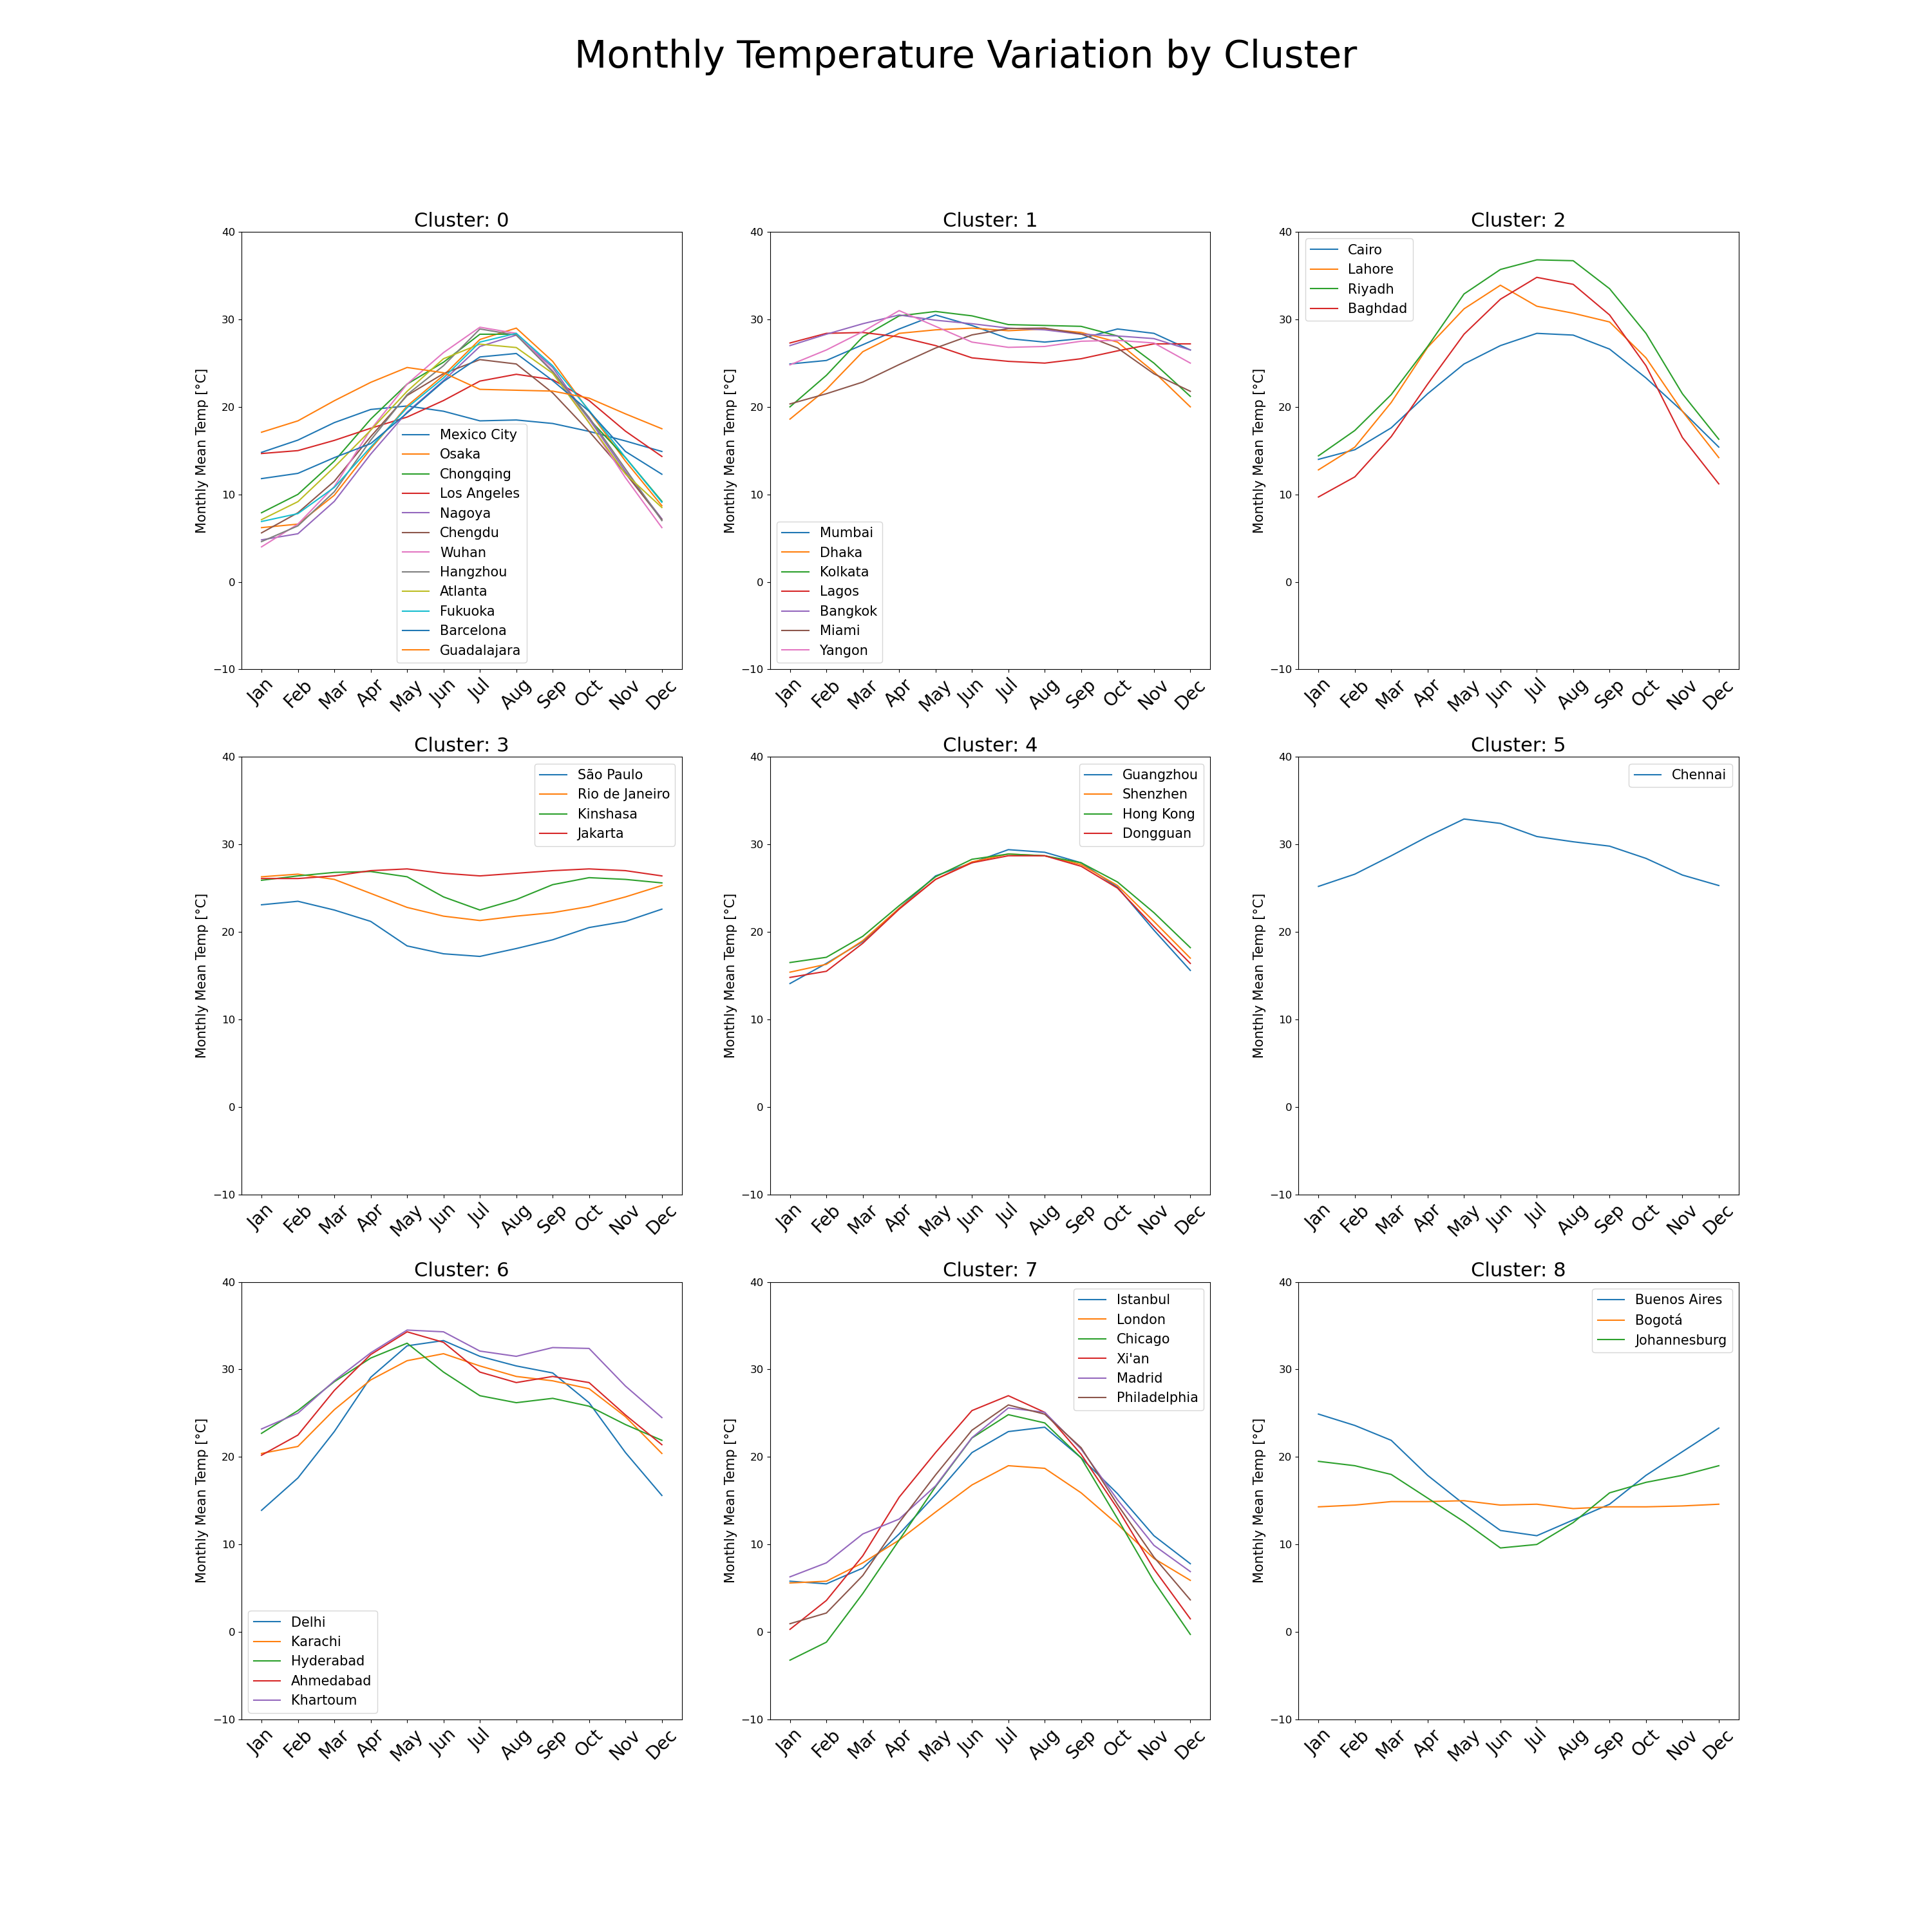

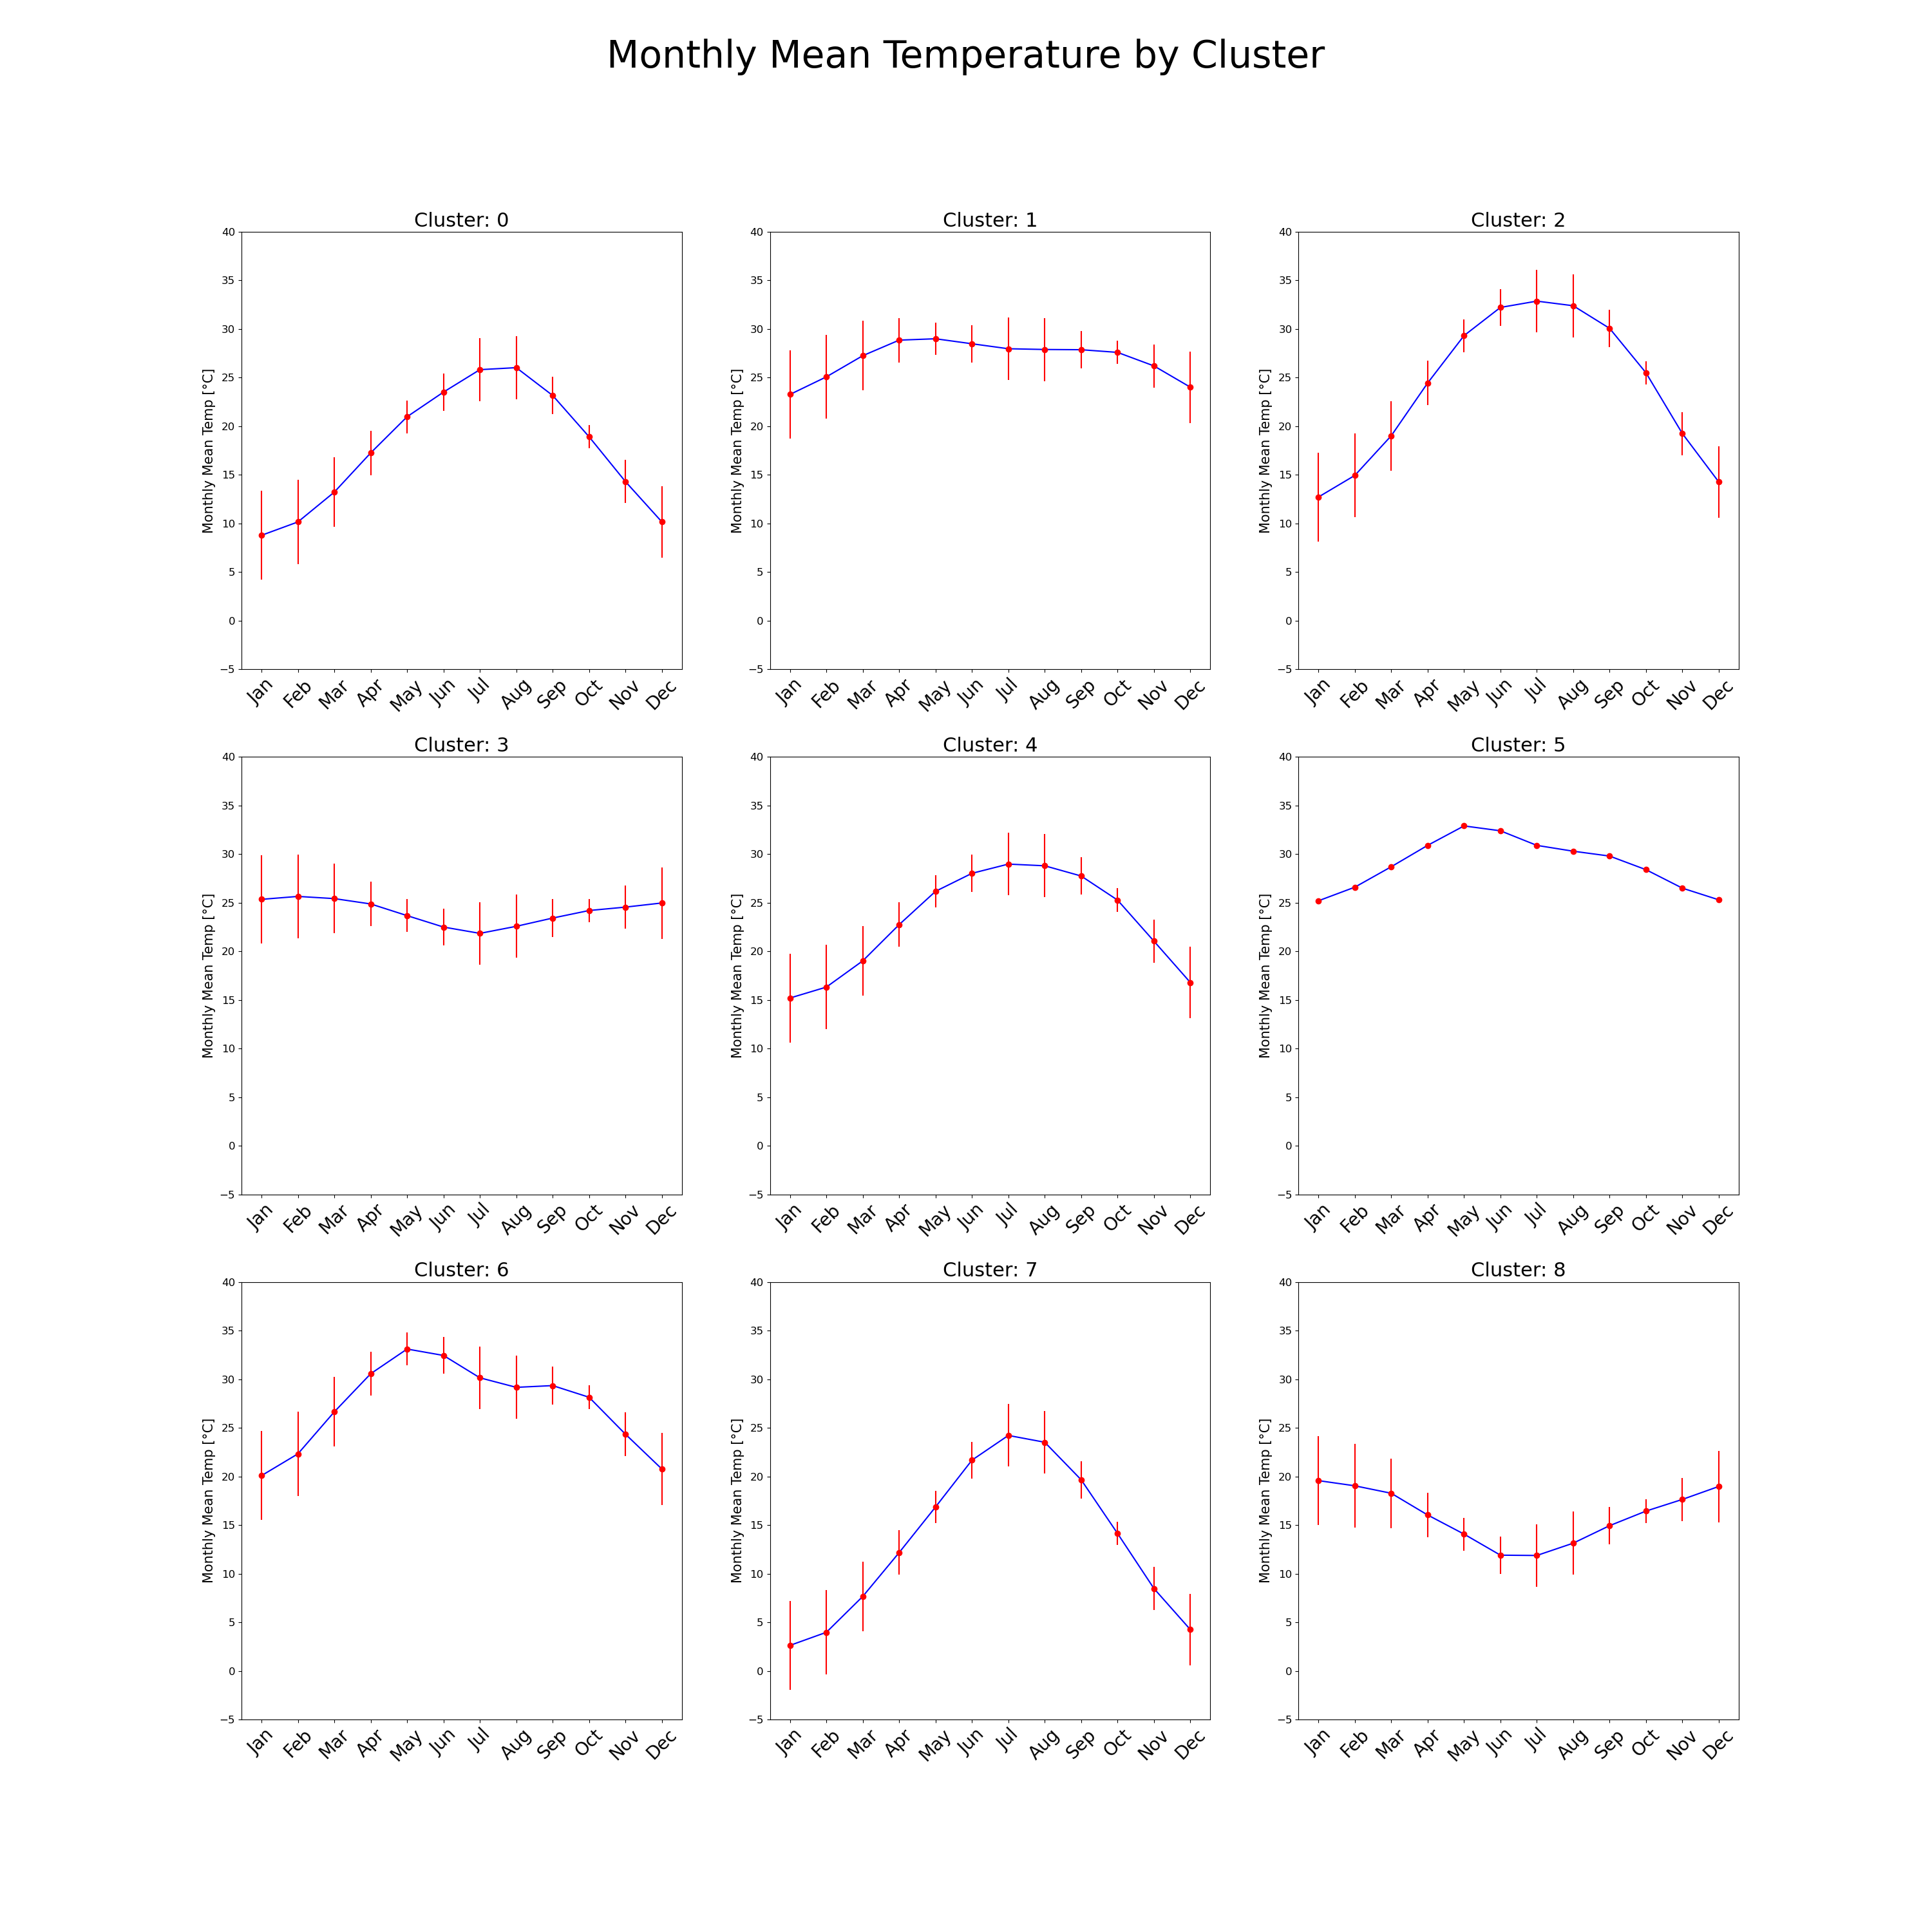

Now, let's see what each of the clusters look like for precipitation:

In [ ]:
fig, axs  = plt.subplots(3, 3)
fig.suptitle('Monthly Precipitation Variation by Cluster', fontsize = 42)
plt.figure(figsize=(20, 20), dpi=80)
plt.rcParams['figure.figsize'] = [30, 30]
plt.rcParams.update({'font.size': 12})

for i in range(9):
    x = i % 3
    y = (i - x) // 3
    df_clusters.get_group(i).loc[:,"Jan Prec":"Dec Prec"].T.plot(ax=axs[y, x])
    axs[y, x].legend(df_clusters.get_group(i)["Name"], fontsize=15)
    axs[y, x].set_ylim(0, 100)
    axs[y, x].set_xticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr",
              "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize = 20,rotation=45)
    axs[y, x].set_ylabel("Monthly Mean Precip. [cm]", fontsize=15)
    axs[y, x].set_title(f'Cluster: {i}', fontsize=22)

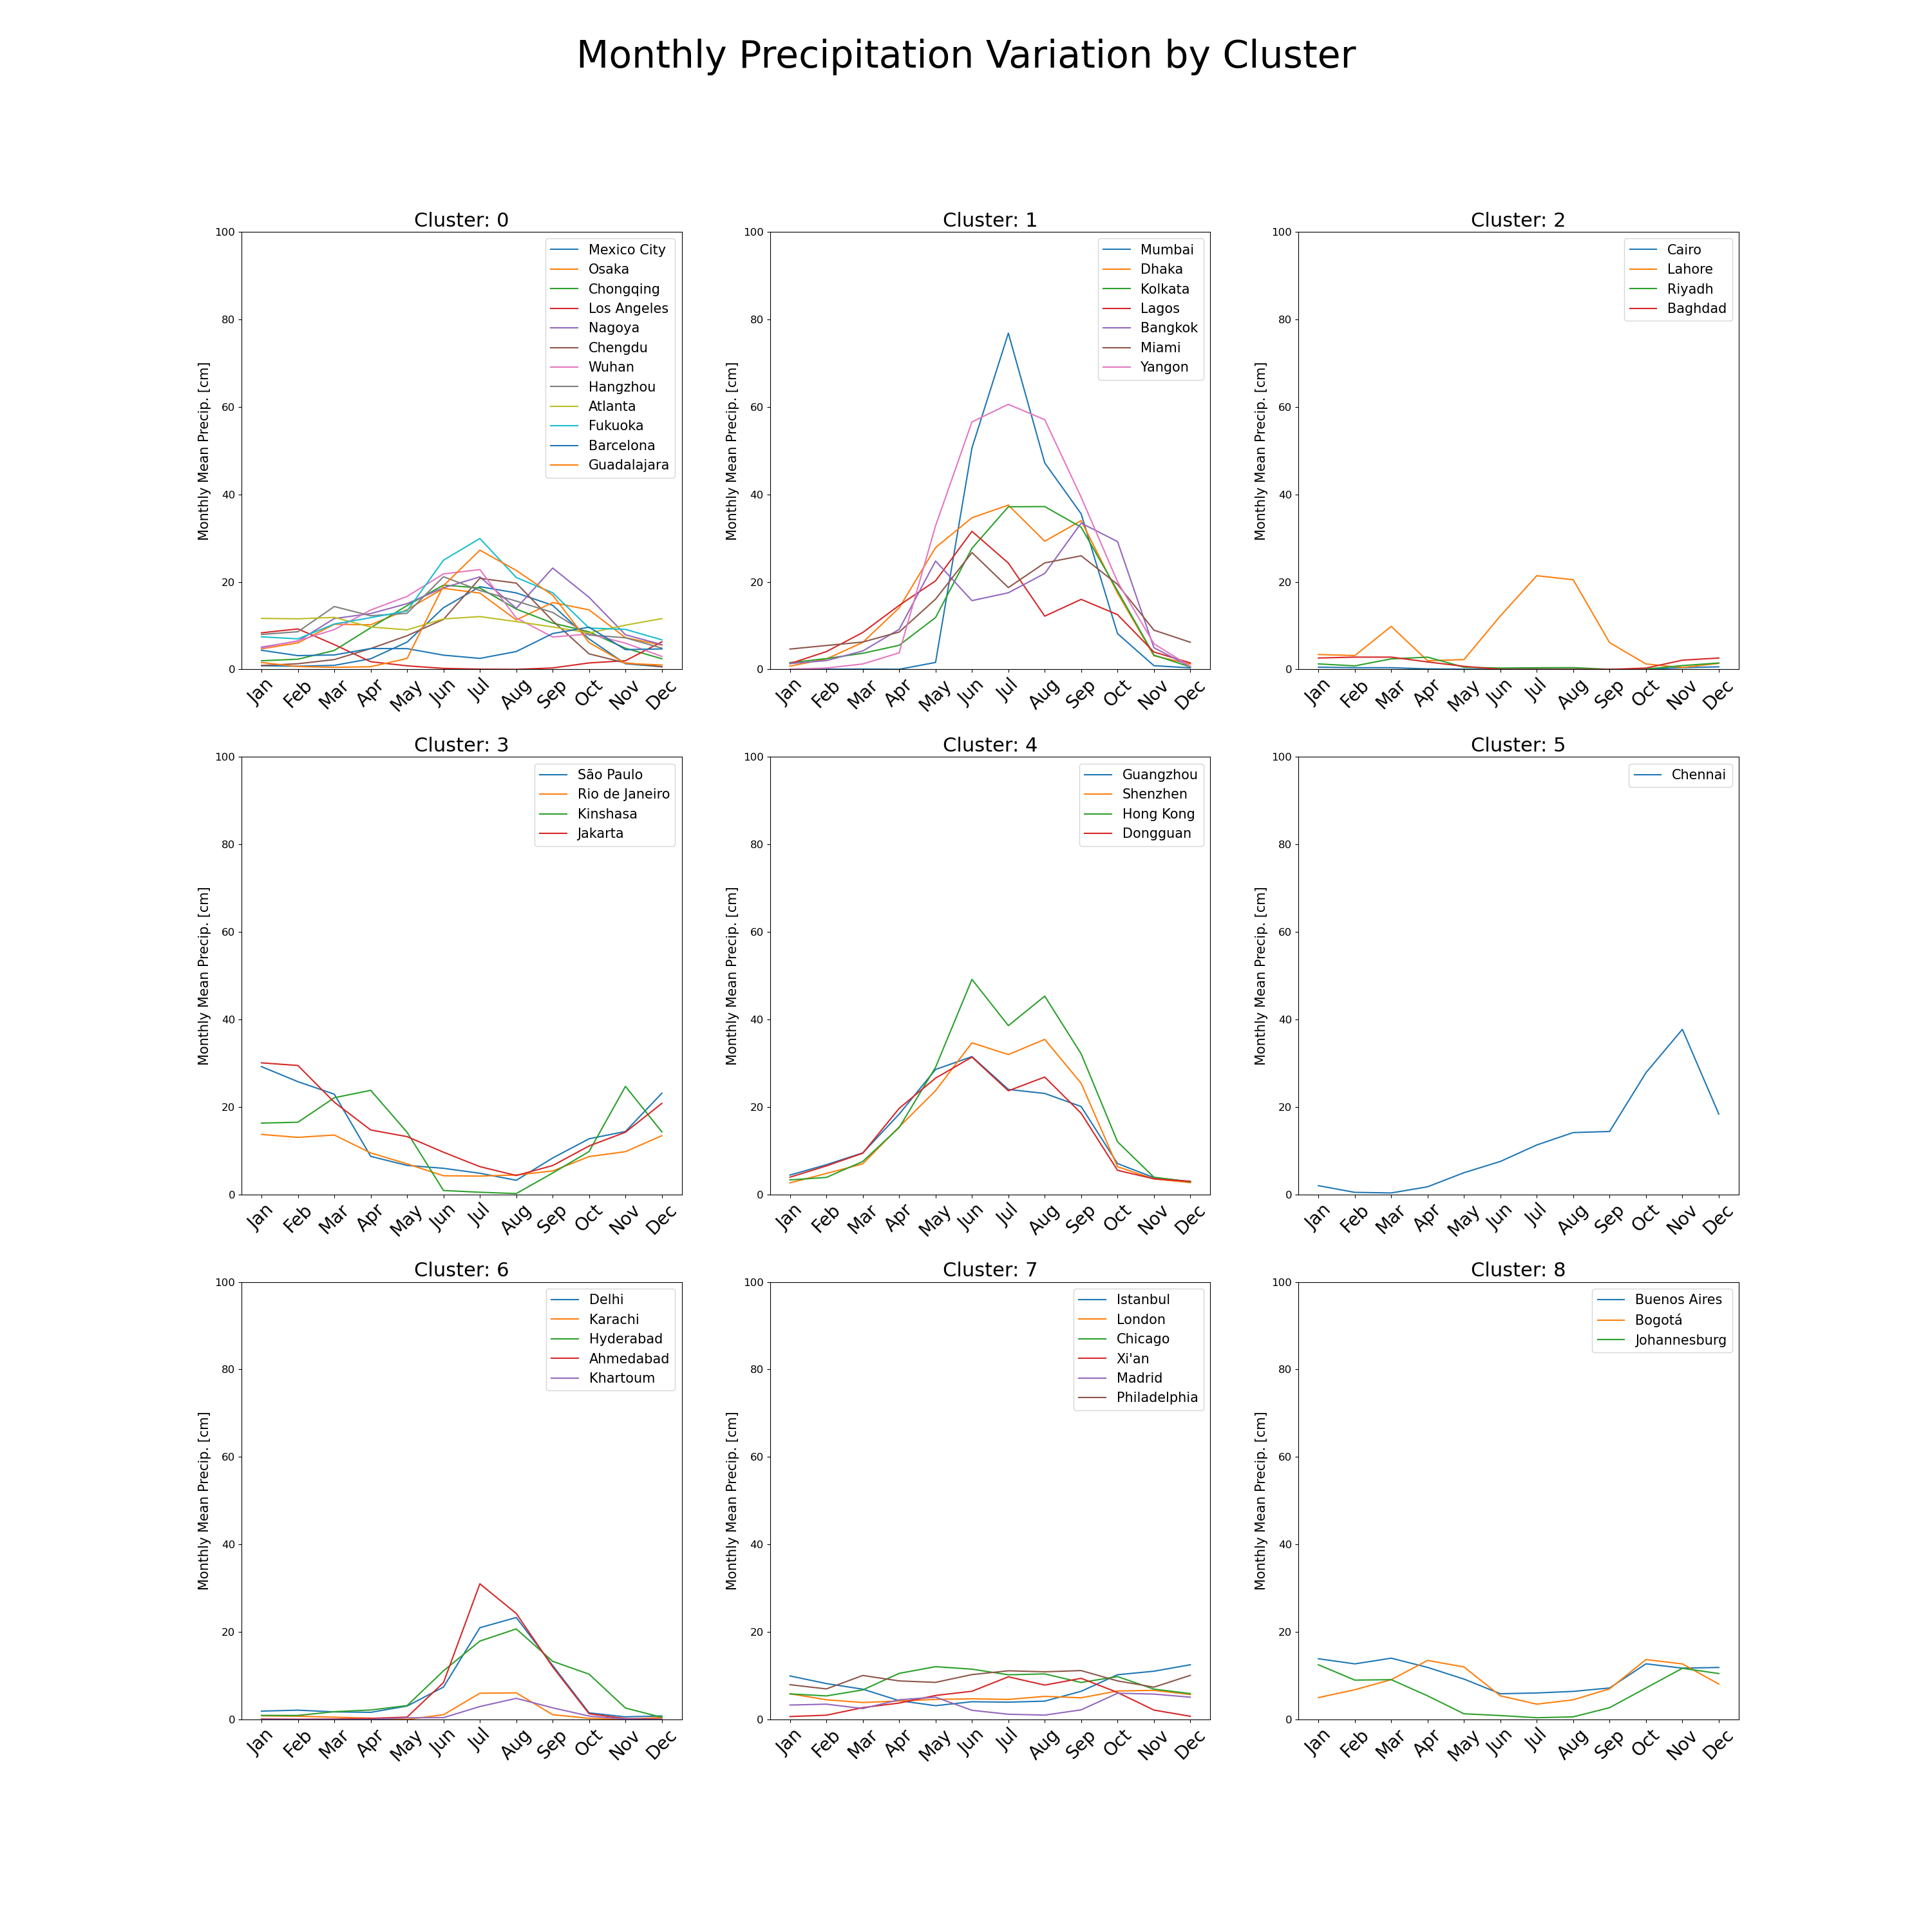

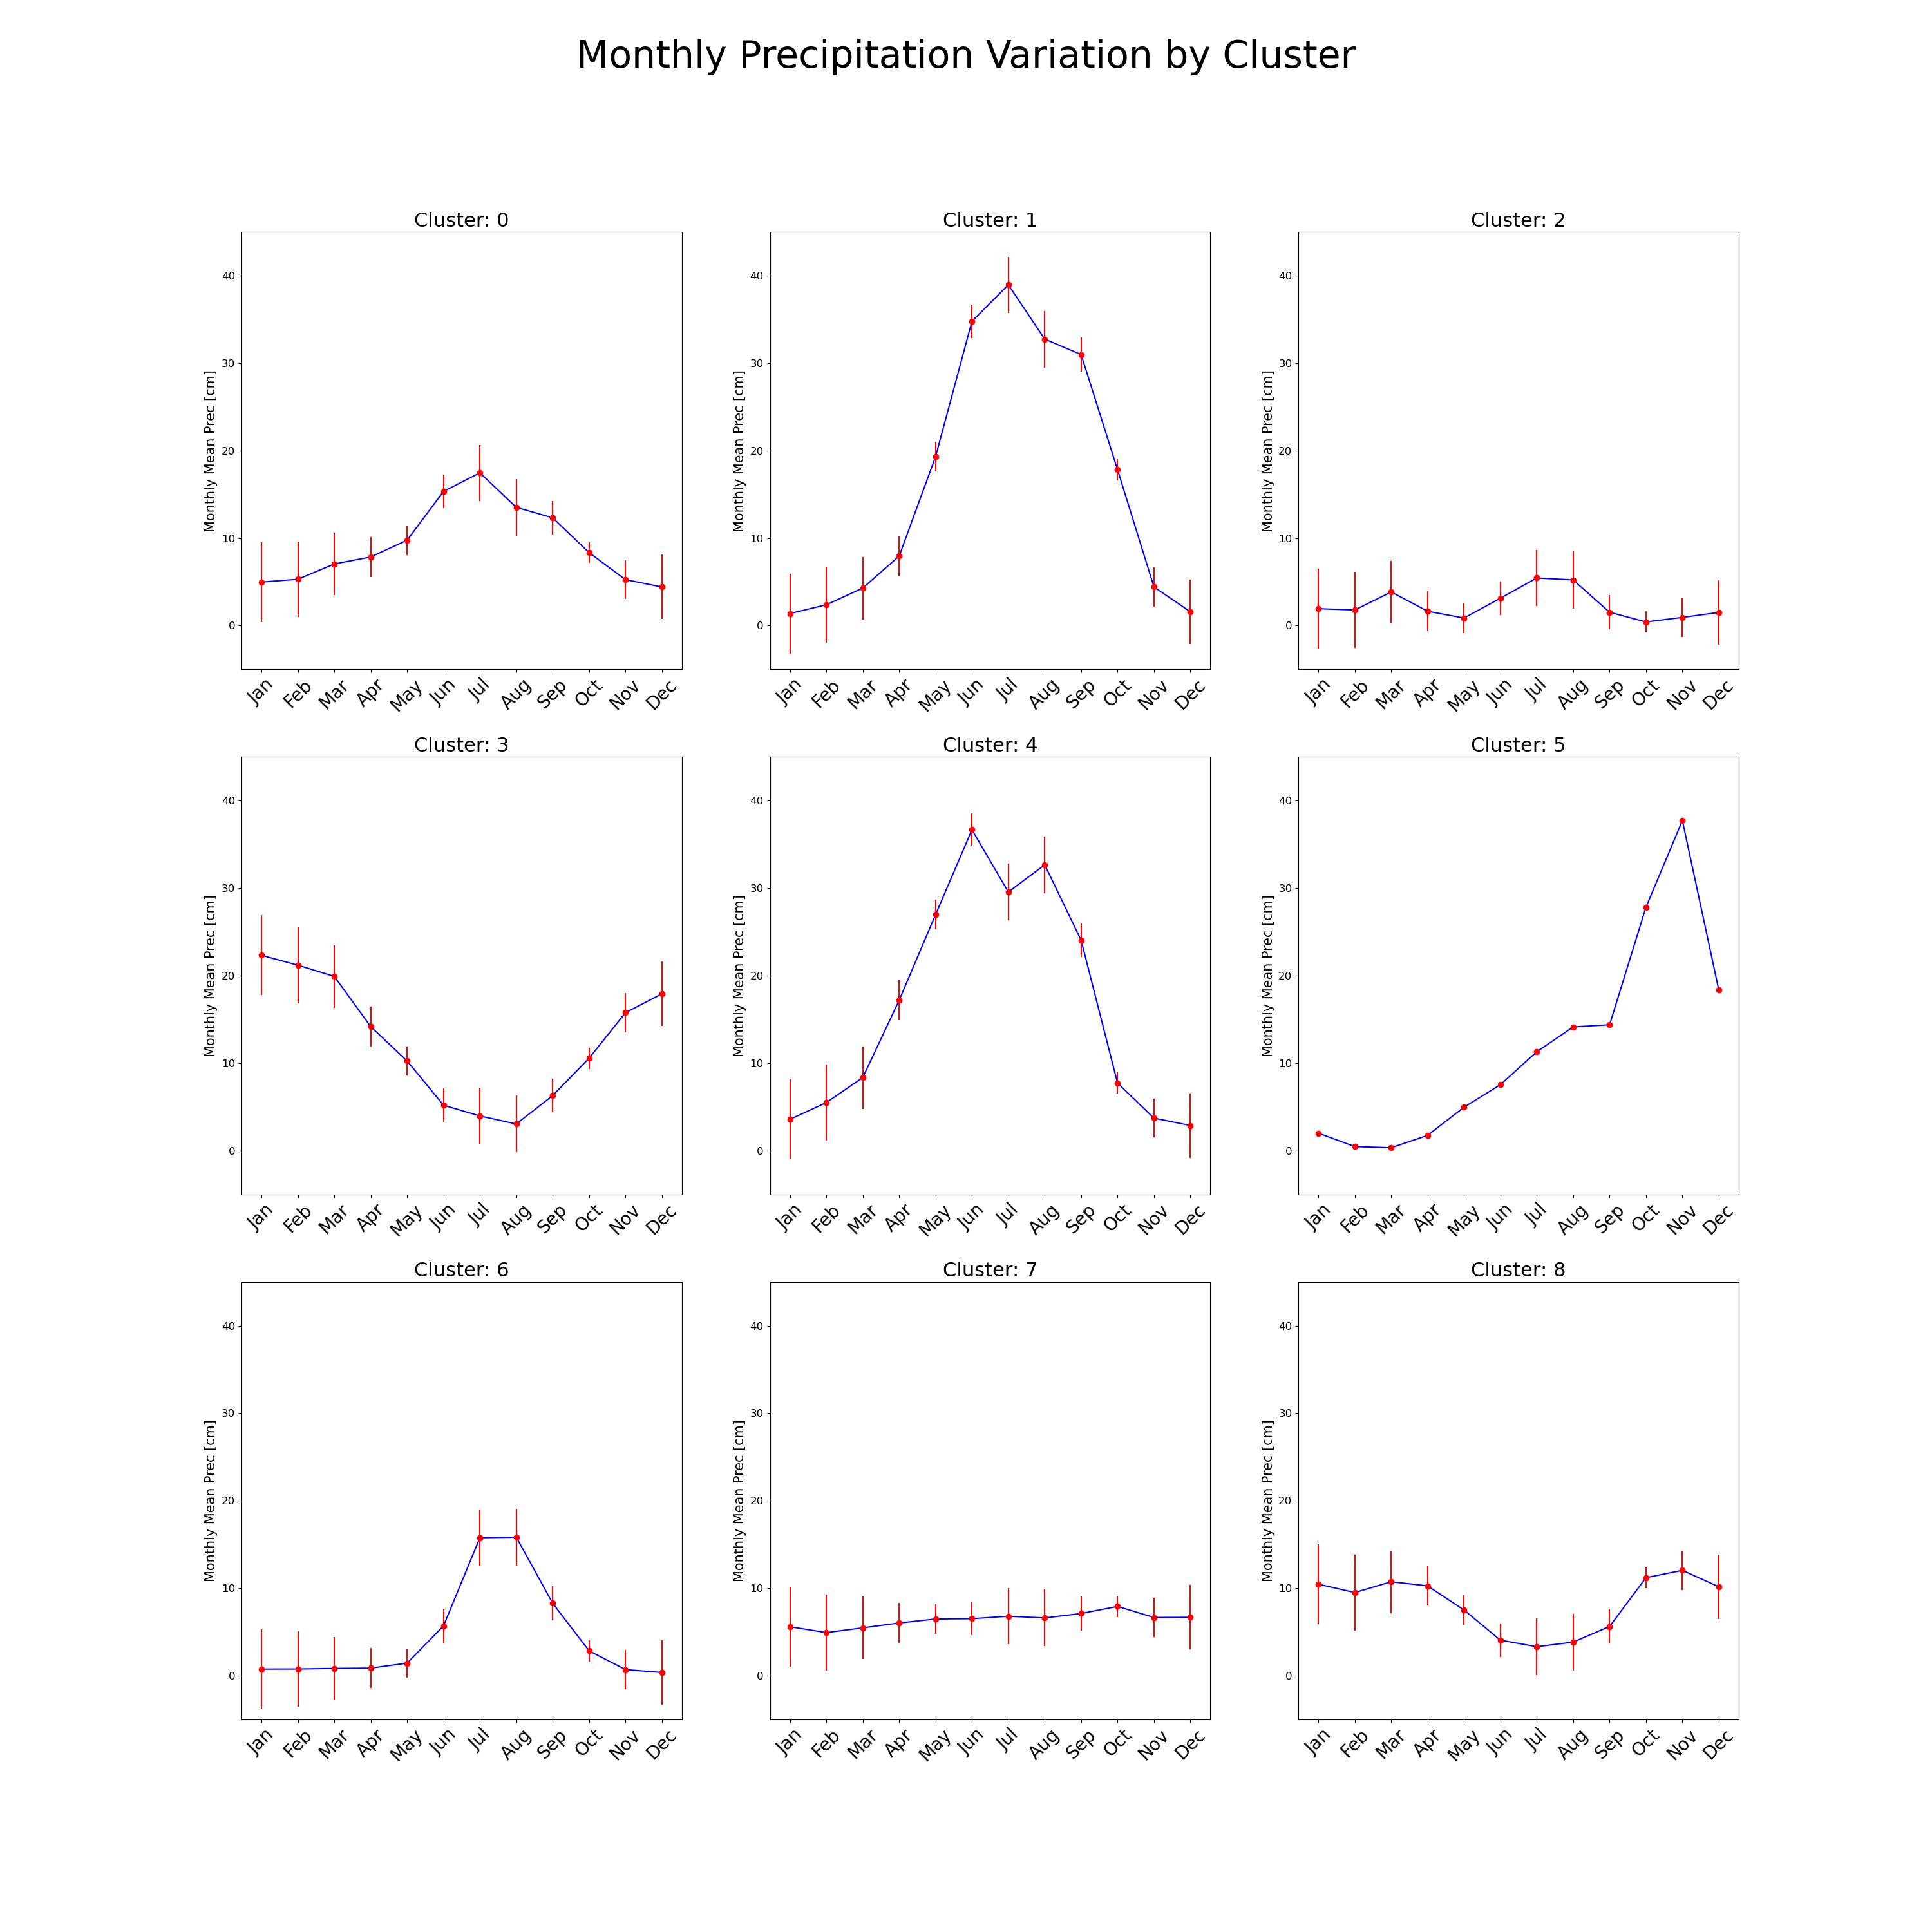

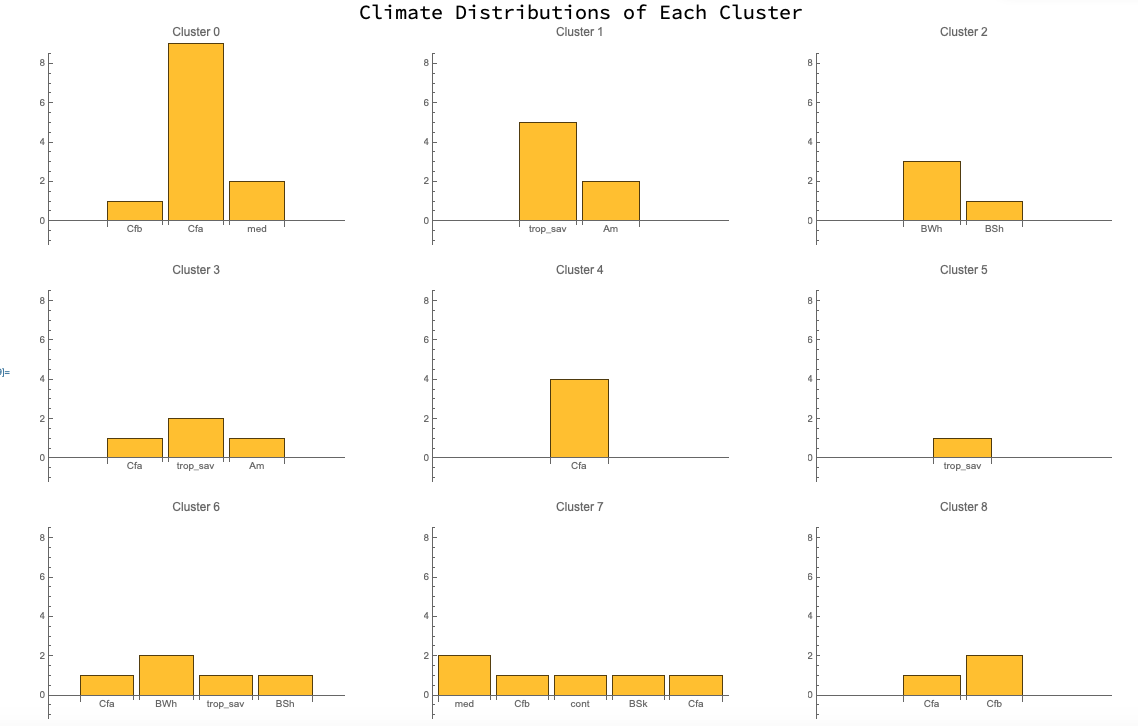
<br>
The distributions of the climates seen within each cluster.

In [75]:
df.to_csv('climate_clusters.csv')

In [77]:
len(df)

46

Additionally, we can get some more insight by looking at the geographic spread of the clusters. The Mathematica code looks like:

<pre>
<code>
Data = Import[File['climate_clusters.csv']][[2;;]];
a = GeoGraphics[
 Table[GeoMarker[SemanticInterpretation[#], 
     Style["+", 
      ColorData["VisibleSpectrum"][400 + ind*(700 - 400)/(9)], 
      FontSize -> 26]] & /@ 
   Flatten[Reap[Sow[#, #[[-1]] == ind] & /@ Data, True][[2]], 1][[All,
      2]], {ind, Range[0, 8]}], GeoProjection -> "Robinson", 
 GeoRange -> "World"];
 
Labeled[Framed[
  Show[a, GeoRange -> "World", 
   Epilog -> {Text[
      Style["Cluster", FontSize -> 14, FontFamily -> "Times"], {-1.9, 
       0.3}], Inset[
      Framed[SwatchLegend[
        Table[ColorData["VisibleSpectrum"][
          400 + i*(700 - 400)/(9)], {i, Range[0, 8]}], 
        Style[#, FontSize -> 14] & /@ {"0", "1", "2", "3", "4", "5", 
          "6", "7", "8"}]], {-1.9, -0.3}]}]], 
 Style["Geographic Spread of Clusters", FontFamily -> "Times", 
  FontSize -> 20], Top]
</code>
</pre>



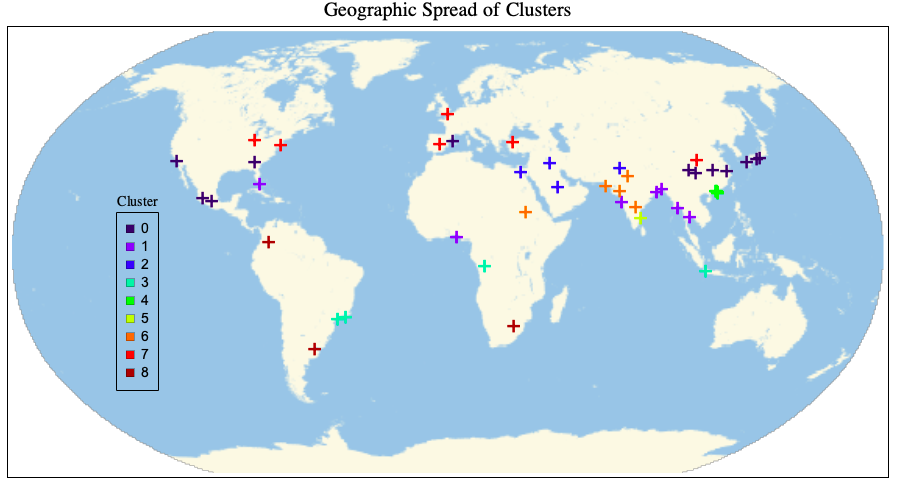

## Discussion

This initial exploration gave some interesting information. Just by looking at the plots of monthly averages, we can see that the algorithm was effective at discriminating between different climate patterns as the plots in any cluster tend to follow each other. 
<br><br>
Additionally, some geographic trends can be observed within clusters. Most notably, cities in cluster 1 tend to occur along coastal regions of the Northern Hemisphere that are close to the equator. Although cities in cluster 6 also occur in the Northern Hemisphere and near the equator, they tend to be further inland. 
<br><br>
The precipitation and temperature plots of clusters 1 and 3 share a similar form, however, there is a noticeable shift in the time of the year that the wet season and warm seasons occur. This is likely related to cluster 1 cities being in the Northern Hemisphere and Cluster 3 cities being in the Southern Hemisphere
<br><br>
Because of the consistency in weather data and geographic factors within the clusters, I believe that KMeans clustering is a viable method to group locations based on climatic features.
<br><br>
Lastly, I was surprised that most of the clusters each contain more than one Köppen type. This finding may support the criticism that this classification scheme relies on arbitrary cutoffs that are not reflected well in the real world. Additionally, many of the articles I used mention their respective cities as being on a 'border' or 'transition' between Köppen zones. Although this may support some of the criticism against the Köppen classification, my study only looked at a small number of cities ($N=46$). One of the more difficult aspects of this project was extracting meaningful classification information from articles. In the future, the retrieval of Köppen types may be optimized by using a natural language processing tool.